In [26]:
import os
import raster_tools as rt

"""
Ouverture et crop
Je souhaite ouvrir les bandes 2, 3 et 4 de mon image sentinel uniquement sur une petite zone.
"""

# Chemin du répertoire dans lequel sont stockées nos images
dir = "/hello/CAM-RANH_2022_06_21_S2A/"

# Voyons-voir ce qu'il y a dedans
print(os.listdir(dir))

['T49PBP_20220621T030551_B01.jp2', 'zone_2.qml', 'T49PBP_20220621T030551_B08.jp2', 'zone_2.tif', 'T49PBP_20220621T030551_B09.jp2', 'zone_1.qml', 'zone_1.tif', 'T49PBP_20220621T030551_B8A.jp2', 'T49PBP_20220621T030551_B05.jp2', 'T49PBP_20220621T030551_B07.jp2', 'T49PBP_20220621T030551_B02.jp2', 'T49PBP_20220621T030551_B06.jp2', 'T49PBP_20220621T030551_B11.jp2', 'T49PBP_20220621T030551_B04.jp2', 'T49PBP_20220621T030551_B03.jp2', 'T49PBP_20220621T030551_B12.jp2', 'T49PBP_20220621T030551_TCI.jp2', 'T49PBP_20220621T030551_B10.jp2', 'zone_crop_sentinel.png', 'T49PBP_20220621T030551_B02.jp2.aux.xml', 'T49PBP_20220621T030551_B03.jp2.aux.xml', 'T49PBP_20220621T030551_B04.jp2.aux.xml']


In [18]:
"""
On souhaite ouvrir les bande 02, 03 et 04. Construisons un motif d'expression régulière permettant d'isoler les noms de ces fichiers.
"""
# Commençons par spécifier l'extension de nos fichiers
motif_v1 = r"\.jp2$" # Ici on dit "Je veux un point (\.), puis jp2 (jp2) et que ce soit la fin de la chaîne ($)." 
                # Il faut mettre un \ avant le point pour le déspécialiser. En fait en regex (regular expression),
                # les . ont une signification particulière : n'importe quel caractère. Nous, on veut que le point
                # soit utilisé ici non pas comme n'importe quel caractère mais vraiment comme un point. D'où le backslash.

# Différencons maintenant les différentes bandes entre elles
motif_v2 = "B[0-9]+" + motif_v1 # On ajoute que le motif dont ressembler à 'B' suivi de un ou plusieurs chiffres avant le premier défini plus haut.

# Voici ce qu'on obtient en testant openManyGeoRaster avec ce motif
bands = rt.openManyGeoRaster(
    directory = dir,
    pattern = motif_v2,
    crop = "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    verbose = False
)
bands.keys()

dict_keys(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12'])

In [23]:
# C'est cool mais ça  chargé toutes les bandes. Si on veut que la 2, 3 et 4, faut customiser un peu notre motif.
motif_v3 = "B0[2-4]" + motif_v1

# Réouverture avec le nouveau motif
bands = rt.openManyGeoRaster(
    directory = dir,
    pattern = motif_v3,
    crop = "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    verbose = False
)
bands.keys()

dict_keys(['B02', 'B03', 'B04'])

<class 'dict'>
pixel size : (10.0, -10.0)
origin     : (227930.0, 1293480.0)
bands      : 1
rows       : 324
columns    : 1310
SCR epsg   : 32649
SCR name   : WGS 84 / UTM zone 49N



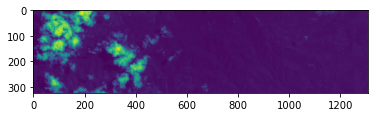

In [24]:
# Super. On a chargé uniquement nos bandes 02, 03 et 04. 
# Voyons maintenant comment se servir du dictionnaire que nous a retourné la fonction openManyGeoRaster.
print(type(bands))
print(bands["B03"])
bands["B03"].quickVisual()

pixel size : (10.0, -10.0)
origin     : (227930.0, 1293480.0)
bands      : 3
rows       : 324
columns    : 1310
SCR epsg   : 32649
SCR name   : WGS 84 / UTM zone 49N



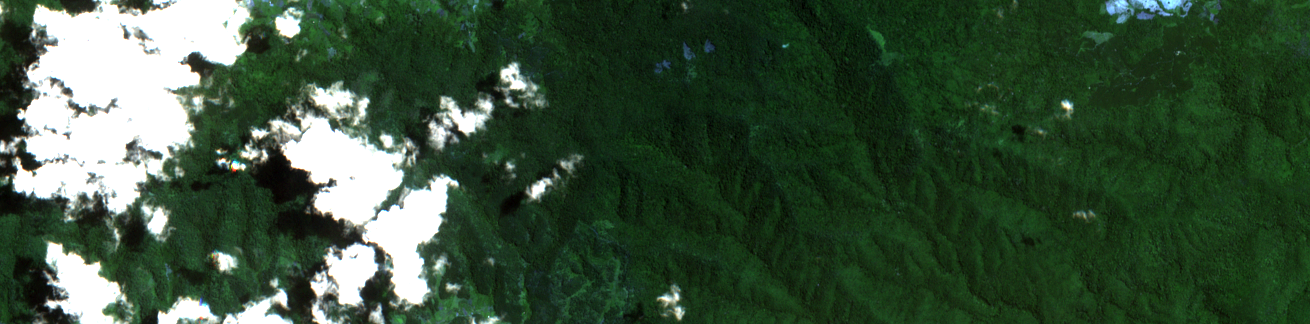

In [25]:
# Et si on stackait toutes nos bandes ? 
stack = rt.stackGeoIms([bands[bandName] for bandName in bands])
print(stack)

# Visu RGB du stack
stack.rgbVisual(brightness=5)

In [ ]:
"""
De manière à pouvoir alimenter des chaînes de traitement, le module raster_tools dispose d'une fonction d'ouverture 
multiple d'images satellites à partir d'un répertoire. Elle s'appelle openManyGeoRaster.

openManyGeoRaster fonctionne exactement comme openGeoRaster. On peut aussi  lui ordonner d'effectuer crop, 
rééchantillonage et reprojection avant le chargement de la matrice. La différence, c'est qu'elle peut appliquer
ces traitements à la chaîne sur une série d'images situées dans un même répertoire, et nous renvoie un 
dictionnaire contenant toutes nos images chargées et pré-traitées.

Comme je l'ai dit on travaille à partir d'un répertoire contenant plusieurs fichiers, et pas un nom de fichier unique. 
Donc au niveau des arguments à renseigner, 'rasterPath' est remplacé par 'directory'. En plus de ça, on a deux nouveaux
arguments qui s'ajoutent à ceux de openGeoRaster, dont nous allons voir l'utilité sur les deux paragraphes suivants.
Si à ce stade vous vous posez les deux questions suivantes, c'est bon signe.

1 - comment on décide quelles images du dossier sont chargées et lesquelles ne le sont pas ?
    Avec l'argument 'pattern'. On doit s'en servir pour renseigner un motif d'expression régulière. Le concept d'expression 
    régulière est utilisée en informatique dans une très large gamme d'utilisations diverses et variées, et on le retrouve
    dans la majorité des langages de programmation. Il y a des livres entiers rédigés à ce sujet, c'est gigantesque. 
    
    Les expressions régulières sont une sorte de langage à part entière permettant de décrire des chaînes de caractères de
    manière générique. Elles permettent de dire par exemple "parmi une série de chaînes de caractère, j'en veux une qui commence 
    par 'S2A_' , qui contient 'B' suivi de deux chiffres et qui termine par '.jp2'". C'est parfait pour détecter des noms 
    d'images au sein de dossier contenant plein de trucs différents. 
    Et au delà de détecter les images, ça nous permet aussi de sélectionner uniquement les images que l'on souhaite à 
    partir de leur nom. C'est très pertinent dans le cadre des dossiers contenant des images sentinel ou landsat par exemple. 

2 - si le retour est un dictionnaire, quel est l'identifiant (la clé) associée à chaque image ? 
    Le second argument ajouté c'est 'endKeyPos'. Il signifie littéralement 'position de fin de la clé'. En fait, le début de la
    clé, ce sera la position de début du motif (dans le nom d'un fichier) et la fin de la clé, ce sera l'argument 'endKeyPos'. 

Exemple : 

    Prenons la chaîne "T49PBP_20220621T030551_B12.jp2". 
    Si je donne le motif suivant :
        'B[0-9]+.jp2" - je déclare que le motif recherché commence par un B, suivi d'un ou plusieurs chiffres compris entre 0 et 9,
        puis par '.jp2'. 
        Donc la position de départ de ce motif sera 23. On pourrait dire que la clé est l'intégralité de la chaîne à partir de ce caractère. 
        On aurait comme clé pour retrouver notre GeoIm parmi les autres "B12.jp2". C'est pas ouf, on s'est fiche du .jp2 ici. Voici pourquoi,
        en disant que l'on coupe la clé à la position '-4' par exemple, on vire '.jp2' et on ne conserver que "B12". 
        Voilà l'utilité de endKeyPos. Par défaut, il est égal à -4.

Bon, le laïus théorique étant terminé, passons à la pratique.
"""
pass